# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать **отток клиентов**. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Импорт библиотек

In [210]:
!pip install mglearn

In [211]:
import mglearn.plots
import mglearn
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from dateutil import relativedelta

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, auc, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from scipy import stats as st

plt.style.use('dark_background')

## Датасет contract

In [212]:
contract = pd.read_csv('datasets/final_provider/contract.csv')
internet = pd.read_csv('datasets/final_provider/internet.csv')
personal = pd.read_csv('datasets/final_provider/personal.csv')
phone = pd.read_csv('datasets/final_provider/phone.csv')

In [213]:
#contract = pd.read_csv('contract.csv')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [214]:
contract.rename(columns={
    'customerID':'customer_id',
    'BeginDate':'begin_date',
    'EndDate':'end_date',
    'Type':'type',
    'PaperlessBilling':'paperless_billing',
    'PaymentMethod':'payment_method',
    'MonthlyCharges':'monthly_charges',
    'TotalCharges':'total_charges',
}, inplace=True)
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [215]:
contract.info()

In [216]:
contract.duplicated().sum()

0

- Загрузили датасет contract
- У нас 7043 записей и нет пропусков

In [217]:
contract['customer_id'].nunique()

7043

In [218]:
pd.to_datetime(contract['begin_date']).describe(datetime_is_numeric=True)

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: begin_date, dtype: object

In [219]:
contract['begin_date'].nunique()

77

In [220]:
contract['end_date'].nunique()

5

In [221]:
pd.to_datetime(contract[contract['end_date'] != 'No']['end_date']).describe(datetime_is_numeric=True)

count                             1869
mean     2019-11-15 21:31:18.009630464
min                2019-10-01 00:00:00
25%                2019-11-01 00:00:00
50%                2019-11-01 00:00:00
75%                2019-12-01 00:00:00
max                2020-01-01 00:00:00
Name: end_date, dtype: object

In [222]:
def show_hist(data, col_name):
    data[col_name].hist()
    plt.xticks(rotation=45)
    plt.ylabel('Количество наблюдений')
    plt.title(f'Распределение {col_name}')
    plt.show()

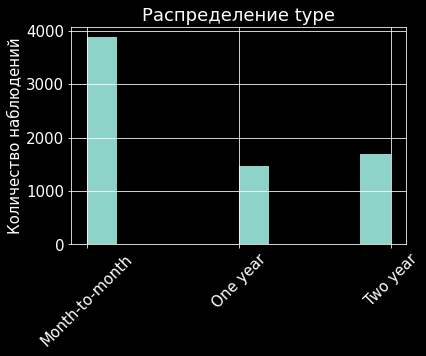

In [223]:
show_hist(contract, 'type')

In [224]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

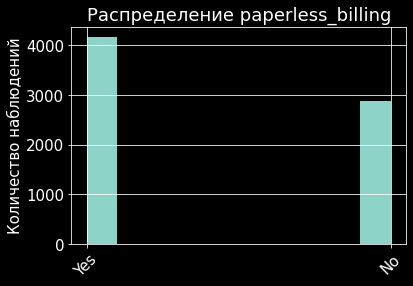

In [225]:
show_hist(contract, 'paperless_billing')

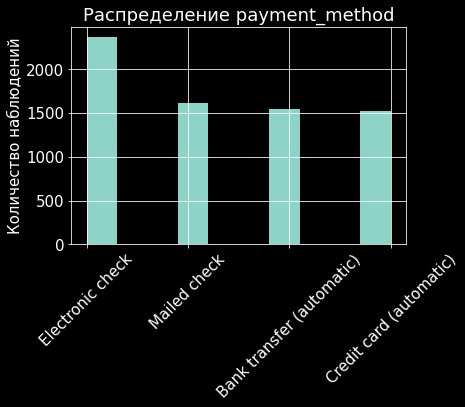

In [226]:
show_hist(contract, 'payment_method')

In [227]:
contract['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

In [228]:
def str_to_numeric(col):
    try:
        return float(col)
    except:
        return 0

In [229]:
t = contract['total_charges'].apply(str_to_numeric)
t.describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

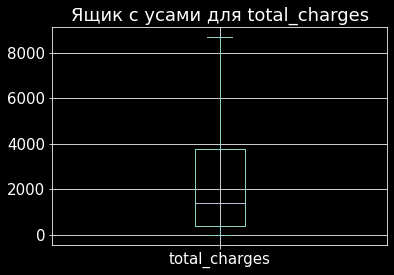

In [230]:
t.plot(kind='box', grid=True)
plt.title("Ящик с усами для total_charges")
plt.show()

- begin_date - распределена равномерно, даты начиная с 2013-10-01 00:00:00 и заканчивая 2020-02-01 00:00:00
- end_date - есть пропуски, это записи, где контракт еще действует, окончание контракта в октябре-декабре 2020 года. Таких наблюдений 1869, то есть у нас добаточно много данных для обучения оттока
- type - тип контракта: больше всего наблюдений month-to-month - около 4000 и значения one year и two years примерно по 1500 наблюдений
- paperless_billing - фича, показывающая в бумажном ли виде чек: чаще встречается ответ yes - это чуть больше 4000 наблюдений, остальные no
- payment_method - способ платежа: привалирует значение Electronic check у практически 2500 наблюдений, остальные 3 значения примерно держатся около 1500 наблюдений
- monthly_charges - ежемесячная плата - в целом есть адекватное и минимальное и максимальное значения данной фичи, среднее и медиана 64 и 70 соответственно, что говорит о допустимом смещении распределения
- total_charges - итоговая плата - здесь есть и очень маленькое значение и очень большое, очень большой "хвост". Так же есть один пропуск который не был виден изначально

## Датасет personal

In [231]:
#personal = pd.read_csv('personal.csv')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [232]:
personal.rename(columns={
    'customerID':'customer_id',
    'SeniorCitizen':'senior_citizen',
    'Partner':'partner',
    'Dependents':'dependents',
}, inplace=True)
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [233]:
personal.info()

In [234]:
personal.duplicated().sum()

0

In [235]:
personal['customer_id'].nunique()

7043

In [236]:
personal['gender'].value_counts(normalize=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

In [237]:
personal['senior_citizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64

In [238]:
personal['partner'].value_counts(normalize=True)

No     0.516967
Yes    0.483033
Name: partner, dtype: float64

In [239]:
personal['dependents'].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64

- customer_id - у нас есть те же id клиентов, что и в датасете contract
- gender - распределение по полу примерно одинаково
- senior_citizen - около 16% наших пользователей пенсионеры
- partner - тут все примерно ровно для yes и no
- dependents - около 30% наблюдений - yes, остальные no

## Датасет internet

In [240]:
#internet = pd.read_csv('internet.csv')
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [241]:
internet.rename(columns={
    'customerID':'customer_id',
    'InternetService':'internet_service',
    'OnlineSecurity':'online_security',
    'OnlineBackup':'online_backup',
    'DeviceProtection':'device_protection',
    'TechSupport':'tech_support',
    'StreamingTV':'streaming_TV',
    'StreamingMovies':'streaming_movies',
}, inplace=True)
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_TV',
       'streaming_movies'],
      dtype='object')

In [242]:
internet.info()

In [243]:
internet['customer_id'].nunique()

5517

In [244]:
internet['internet_service'].value_counts(normalize=True)

Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64

In [245]:
internet['online_security'].value_counts(normalize=True)

No     0.63404
Yes    0.36596
Name: online_security, dtype: float64

In [246]:
internet['online_backup'].value_counts(normalize=True)

No     0.559724
Yes    0.440276
Name: online_backup, dtype: float64

In [247]:
internet['device_protection'].value_counts(normalize=True)

No     0.560993
Yes    0.439007
Name: device_protection, dtype: float64

In [248]:
internet['tech_support'].value_counts(normalize=True)

No     0.629509
Yes    0.370491
Name: tech_support, dtype: float64

In [249]:
internet['streaming_TV'].value_counts(normalize=True)

No     0.509335
Yes    0.490665
Name: streaming_TV, dtype: float64

In [250]:
internet['streaming_movies'].value_counts(normalize=True)

No     0.504803
Yes    0.495197
Name: streaming_movies, dtype: float64

- customer_id - у нас уже меньше записей по сравнению с personal, не все пользуются интернетом
- internet_service - 56% клиентов, пользующихся интернетом подключены по технологии Fiber optic, а 44% по DSL
- online_security - блокировку небезопасных сайтов используют 36.5%, остальные нет
- online_backup - Облачное хранилище файлов для резервного копирования данных используют 44%
- device_protection - антивирус исользуют ~44%
- tech_support - Выделенная линия технической поддержки у 37% пользователей интернета
- streaming_TV и streaming_movies стриминговое телевидение и каталог фильмов у 49% пользователей

## Датасет phone

In [251]:
#phone = pd.read_csv('phone.csv')
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [252]:
phone.info()

In [253]:
phone.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [254]:
phone.rename(columns={
    'customerID':'customer_id',
    'MultipleLines':'multiple_lines',
}, inplace=True)
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [255]:
phone['customer_id'].nunique()

6361

In [256]:
phone['multiple_lines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: multiple_lines, dtype: float64

- customer_id - опять наш id клиента, их у нас 6361 из 7043 абонентов
- multiple_lines - многоканальный телефон у 46% клиентов

# Постановка задачи оттока клиентов

0. Анализ аудитории
1. определяем что мы считаем оттоком
2. выбираем тип задачи (модели - бинарная/многоклассовая классификация, регрессия и т.д)
3. определяем горизонт прогнозирования (с учетом времени на удержание)
4. решаем, как именно мы будем оценивать качество нашей будущей модели (метрики)
5. планируем дизайн эксперимента

    Что такое задача оттока?
- "Интуитивно" понятие оттока понятно - был пользователь, который пользовался нашим сервисом, а потом вдруг перестал это делать. Например перешел в другую телекоммуникационную компанию, стал пользоваться другим сервисом и т.д (в зависимости от того, какая у нас сфера).

    Зачем прогнозировать задачу оттока?
1. Чем больше у нас пользователей, тем выше прибыль (особенно, если большая доля выручки - это рекламная монетизация)
2. Больше пользователей = привлечение новых + удержание существующих (уменьшение оттока уже существующих)
3. У привлечения новых и удержания "старых" разная экономическая эффективность

    Уточнения от бизнеса:
- Все зависит от бизнеса и может оказаться так, что удержать старого будет стоить дороже чем привлекать нового
- А может оказаться так, что удерживать нет смысла так как клиент не приносил нам много прибыли, или вовсе был "проблемным"(не платил во время, или часто заказывал и делал возвраты(недавний кейс озона))

    Что у нас есть сейчас?
2. Мы первично оценили данные и выявили что у нас 7043 клиентов, 5517 из них пользуются услугой интернет и связанными с ним услугами, 6361 из них пользуются услугой телефона.
3. Из 7043 клиентов 1869 нас покинули.
4. Данных о клиентах, заключивших контракт с 2013-10-01 по 2020-02-01 при этом покинувшие нас с 2019-10-01 по 2020-01-01, то есть 3 месяца.

    Возможно стоит добавить новые фичи?
- Например сколько в день/месяц/год клиент тратил на услуги компании?
- Сколько времени клиент пользуется услугами компании?

    Метрики удержания
- return rate = (текущее количество активных пользователей из набора данных)/(общее количество пользователей из набора данных)*100
- churn rate = (количество пользователей из набора данных, ушедших в отток)/(общее количество пользователей из набора данных)*100

    Можно выделить несколько шагов в оценке эффективности удержания клиента:

1. провести анализ аудитории: сегментация, ключевые показатели и т.д
2. формализовать постановку задачи и построить модель. при построении модели учесть, что ML-модель может ошибаться и в итоге в кампанию по удержанию попадут в том числе и те игроки, которые не собирались от нас уходить. Как следствие, на их удержание будут потрачены деньги (им будет сделано более выгодное предложение, хотя этого можно было и не делать)
3. запустить компанию по удержанию (с учетом прогнозов п.2) и оценить результаты

# Анализ данных

In [257]:
df = personal.merge(contract, how='left', on='customer_id').\
    merge(internet, how='left', on='customer_id').\
    merge(phone, how='left', on='customer_id')
df.info()

## Введем новую фичу, отвечающую за отток клиента

In [258]:
df['is_exited'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [259]:
df.tail(3)

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,multiple_lines,is_exited
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,...,346.45,DSL,Yes,No,No,No,No,No,NaN,0
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,...,306.6,Fiber optic,No,No,No,No,No,No,Yes,1
7042,3186-AJIEK,Male,0,No,No,2014-08-01,No,Two year,Yes,Bank transfer (automatic),...,6844.5,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No,0


In [260]:
df['is_exited'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: is_exited, dtype: float64

26.5% клиентов ушли в отток

## Pаспределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл

Изучим наших клиентов, посмотрим на клиентов которых ушли, на их количественные характеристики и тех кто с нами

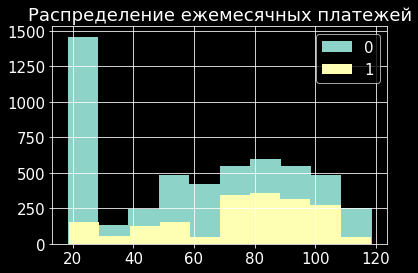

In [261]:
df[df['is_exited'] == 0]['monthly_charges'].hist()
df[df['is_exited'] == 1]['monthly_charges'].hist()
plt.title('Распределение ежемесячных платежей')
plt.legend(['0', '1'])
plt.show()

In [262]:
df[df['is_exited'] == 0]['monthly_charges'].describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: monthly_charges, dtype: float64

In [263]:
df[df['is_exited'] == 1]['monthly_charges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: monthly_charges, dtype: float64

- Можно отметить, что клиенты, которые ушли в среднем платят в месяц больше тех кто не ушел: 74 против 61.
- Те, кто не ушли в отток часто платят мало, это около 20 в месяц и таких наблюдений более 1400, в то время как те кто ушли и платили около 20 - их всего менее 200.
- Такие же "провалы" наблюдаются в платежах около 60 и 110, в остальном графики распределения изменяются примерно одинаково.
- Можно сделать вывод что цена ежемесячной платы влияет на отток в той части, если клиент платит минимальную сумму платежа, то он врядли уйдет, а нам соответственно "выгоднее" сосредоточиться на тех клиентах, которые платили более 70 в месяц(допустим), так как тренд на гистограмме возрастает резко именно в этом месте для тех кто ушел.

## Изучим клиентов которые пользуются телефонией

In [264]:
df['is_phone'] = df['multiple_lines'].apply(lambda x: 1 if (x == 'Yes') or (x == 'No') else 0)

In [265]:
df.head(3)

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,multiple_lines,is_exited,is_phone
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,NaN,0,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,0,1
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,1,1


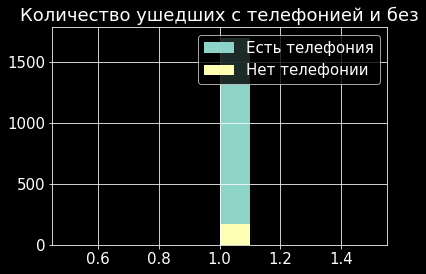

In [266]:
df[(df['is_exited'] == 1) & (df['is_phone'] == 1)]['is_exited'].hist()
df[(df['is_exited'] == 1) & (df['is_phone'] == 0)]['is_exited'].hist()
plt.title('Количество ушедших с телефонией и без')
plt.legend(['Есть телефония', 'Нет телефонии'])
plt.show()

In [267]:
df[(df['is_exited'] == 1)]['is_phone'].value_counts(normalize=True, dropna=False)

1    0.909042
0    0.090958
Name: is_phone, dtype: float64

In [268]:
df[(df['is_exited'] == 0)]['is_phone'].value_counts(normalize=True, dropna=False)

1    0.901044
0    0.098956
Name: is_phone, dtype: float64

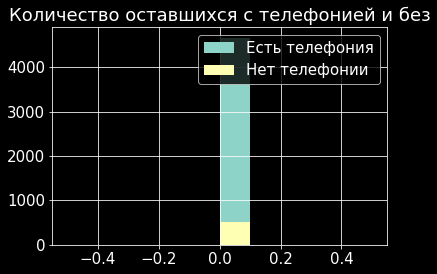

In [269]:
df[(df['is_exited'] == 0) & (df['is_phone'] == 1)]['is_exited'].hist()
df[(df['is_exited'] == 0) & (df['is_phone'] == 0)]['is_exited'].hist()
plt.title('Количество оставшихся с телефонией и без')
plt.legend(['Есть телефония', 'Нет телефонии'])
plt.show()

In [270]:
df[(df['is_exited'] == 0)]['is_phone'].value_counts(normalize=True)

1    0.901044
0    0.098956
Name: is_phone, dtype: float64

Видим, что из тех кто ушел 90% имели телефонию, но и из тех кто остался те же 90% имеют телефонию, скорее всего этот признак не имеет значения

## Изучим клиентов которые пользуются интернетом

In [271]:
df['is_internet'] = df['internet_service'].apply(lambda x: 1 if (x == 'DSL') or (x == 'Fiber optic') else 0)

In [272]:
df.sample(3)

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,online_security,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,multiple_lines,is_exited,is_phone,is_internet
6718,8676-TRMJS,Male,0,No,No,2019-10-01,2020-01-01 00:00:00,Month-to-month,No,Mailed check,...,No,No,No,No,No,No,Yes,1,1,1
5755,5937-EORGB,Male,1,Yes,No,2018-11-01,No,Month-to-month,Yes,Electronic check,...,Yes,No,Yes,No,Yes,No,Yes,0,1,1
2473,6164-HXUGH,Female,0,Yes,Yes,2019-08-01,No,Month-to-month,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,NaN,No,0,1,0


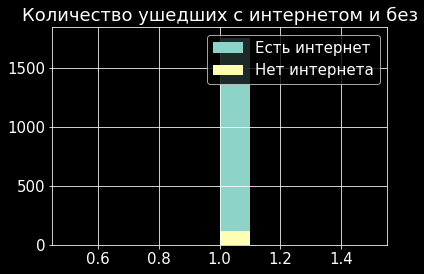

In [273]:
df[(df['is_exited'] == 1) & (df['is_internet'] == 1)]['is_exited'].hist()
df[(df['is_exited'] == 1) & (df['is_internet'] == 0)]['is_exited'].hist()
plt.title('Количество ушедших с интернетом и без')
plt.legend(['Есть интернет', 'Нет интернета'])
plt.show()

In [274]:
df[(df['is_exited'] == 1)]['is_internet'].value_counts(normalize=True, dropna=False)

1    0.93954
0    0.06046
Name: is_internet, dtype: float64

In [275]:
df[(df['is_exited'] == 0)]['is_internet'].value_counts(normalize=True, dropna=False)

1    0.726904
0    0.273096
Name: is_internet, dtype: float64

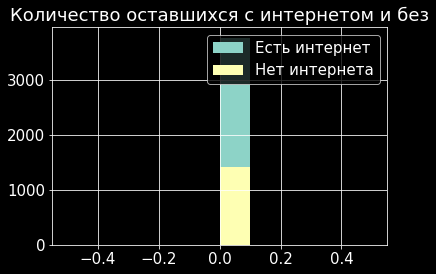

In [276]:
df[(df['is_exited'] == 0) & (df['is_internet'] == 1)]['is_exited'].hist()
df[(df['is_exited'] == 0) & (df['is_internet'] == 0)]['is_exited'].hist()
plt.title('Количество оставшихся с интернетом и без')
plt.legend(['Есть интернет', 'Нет интернета'])
plt.show()

In [277]:
df[(df['is_exited'] == 0)]['is_internet'].value_counts(normalize=True)

1    0.726904
0    0.273096
Name: is_internet, dtype: float64

Из тех кто ушел 93% пользовались интернетом, а из тех кто остался 72% пользуются интернетом. Доля пользователей интернетом в оттоке гораздо выше.

## Как долго клиент пользуется услугой

Есть предположение, что есть зависимость от того как долго клиент пользуется услугой и фактом его ухода

In [278]:
end_point = pd.to_datetime('2020-02-01')
end_point

Timestamp('2020-02-01 00:00:00')

In [279]:
# подсчитываем сколько клиент пользовался услугой
def duration_use(df):
    if df['end_date'] == 'No':
        r = relativedelta.relativedelta(end_point, pd.to_datetime(df['begin_date']))
        return (r.years * 12) + r.months
    r = relativedelta.relativedelta(pd.to_datetime(df['end_date']), pd.to_datetime(df['begin_date']))
    return (r.years * 12) + r.months

In [280]:
df['duration_use'] = df.apply(duration_use, axis=1)

In [281]:
df[['begin_date', 'end_date', 'duration_use']].head()

,begin_date,end_date,duration_use
0,2020-01-01,No,1
1,2017-04-01,No,34
2,2019-10-01,2019-12-01 00:00:00,2
3,2016-05-01,No,45
4,2019-09-01,2019-11-01 00:00:00,2


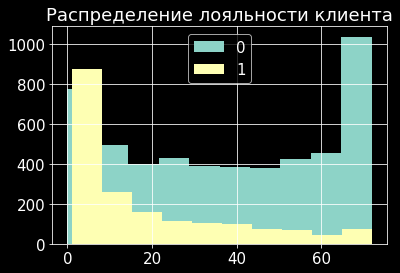

In [282]:
df[df['is_exited'] == 0]['duration_use'].hist()
df[df['is_exited'] == 1]['duration_use'].hist()
plt.title('Распределение лояльности клиента')
plt.legend(['0', '1'])
plt.show()

In [283]:
df[df['is_exited'] == 0]['duration_use'].describe()

count    5174.000000
mean       37.569965
std        24.113777
min         0.000000
25%        15.000000
50%        38.000000
75%        61.000000
max        72.000000
Name: duration_use, dtype: float64

In [284]:
df[df['is_exited'] == 1]['duration_use'].describe()

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: duration_use, dtype: float64

- На графике виден явный тренд: большинство клиентов уходят в первые 12 месяцев
- Клиенты которые не ушли распределены равномерно(здесь надо оговориться что наши данные могут быть неравномеры по причине того, что у нас есть клиенты которые только недавно стали клиентами и у них будет 2 месяца и те кто давно ушел и тоже пропользовался 2 месяца сервисом)

## Как тип пакета клиента влияет на отток клиентов

In [285]:
df.groupby(['type'])['is_exited'].agg(['count', 'sum'])

,count,sum
type,,
Month-to-month,3875,1655
One year,1473,166
Two year,1695,48


Видим, что клиенты которые имеют тип контракта month-to-month более склонны уодить в отток, чем остальные. Даже можно предположить чем длительнее тип контракта у клиента, тем дольше он задерживается. Я бы предложила ввести отделу маркетинга новый тип пакета - например, на 6 месяцев, и выгодные условия перехода для тех, у кого контракт на month-to-month. Т.о. можно было бы перетянуть клиентов из одной группы в другую и косвенным образом снизить отток.

## Посмотрим на зависимость оттока от месяца подключения

In [286]:
t = df.copy()
t['begin_date_month'] = df['begin_date'].apply(lambda x: pd.to_datetime(x).month)

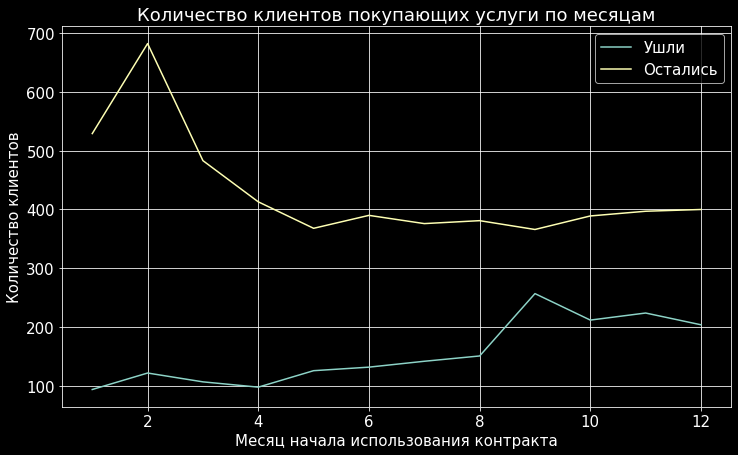

In [287]:
t[t['is_exited'] == 1].groupby('begin_date_month')['customer_id'].agg('count').plot(
    title='Количество клиентов покупающих услуги по месяцам', figsize=(12, 7), grid=True,
)
t[t['is_exited'] == 0].groupby('begin_date_month')['customer_id'].agg('count').plot(
    title='Количество клиентов покупающих услуги по месяцам', figsize=(12, 7), grid=True,
)
plt.legend(["Ушли", "Остались"])
plt.xlabel("Месяц начала использования контракта")
plt.ylabel("Количество клиентов")
plt.show()

In [288]:
t[t['begin_date_month'] == 2]['partner'].value_counts(normalize=True)

Yes    0.670398
No     0.329602
Name: partner, dtype: float64

In [289]:
t[t['begin_date_month'] == 2]['type'].value_counts(normalize=True)

Two year          0.554726
Month-to-month    0.278607
One year          0.166667
Name: type, dtype: float64

Как мы помним изначально у нас 0.52(No) и 0.48(Yes) соотношение по признаку partner, но в феврале месяце чаще подключаются к телеком услугам те, у кого признак Yes, это на 19% больше чем в среднем по году, этот инсайт можно передать в отдел маркетинга, возможно необходимо доработать тарифы для клиентов с признаком patner=Yes. Если посмотреть на соотношение в феврале по типу контракта, то мы видим наше подтверждение что у нас 55% берут контракт на 2 года, но затем следуют те, что на ежемесячные платежи, вот их скорее всего можно подтянуть на 1-годовой контракт.

In [290]:
t[t['begin_date_month'] == 9]['type'].value_counts(normalize=True)

Month-to-month    0.670947
One year          0.199037
Two year          0.130016
Name: type, dtype: float64

In [291]:
t[t['begin_date_month'] == 9]['partner'].value_counts(normalize=True)

No     0.609952
Yes    0.390048
Name: partner, dtype: float64

А в сентябре у нас сильный перевес в сторону тех кто берет контракт на помесячную оплату, здесь точно стоит поработать с аудиторией, по нашим признакам(gender, senior_citizen, partner, dependents не нашла отклонений, возможно здесь речь о том, что взрослые подключают услуги телекома подросткам - 1 сентября). Небольшой рост от общего числа наблюдений есть для фичи patner=No - 9%.

In [292]:
t[t['begin_date_month'] == 11]['partner'].value_counts(normalize=True)

No     0.637681
Yes    0.362319
Name: partner, dtype: float64

In [293]:
t[t['begin_date_month'] == 11]['type'].value_counts(normalize=True)

Month-to-month    0.658615
One year          0.198068
Two year          0.143317
Name: type, dtype: float64

Здесь так же отклонение от общих данных в 12% для  тех у кого partner=No. По контрактам ситуация аналогичная как в сентябре.

## Корреляция фичей

In [294]:
import seaborn as sns
cm = sns.dark_palette("green", as_cmap=True)

In [295]:
df.corr().style.background_gradient(cmap=cm)

,senior_citizen,monthly_charges,is_exited,is_phone,is_internet,duration_use
senior_citizen,1.000000,0.220173,0.150889,0.008576,0.182742,0.016567
monthly_charges,0.220173,1.000000,0.193356,0.247398,0.763557,0.247900
is_exited,0.150889,0.193356,1.000000,0.011942,0.227890,-0.352229
is_phone,0.008576,0.247398,0.011942,1.000000,-0.172209,0.008448
is_internet,0.182742,0.763557,0.227890,-0.172209,1.000000,0.039062
duration_use,0.016567,0.247900,-0.352229,0.008448,0.039062,1.000000


# Feature engineering

In [296]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,multiple_lines,is_exited,is_phone,is_internet,duration_use
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,...,Yes,No,No,No,No,NaN,0,0,1,1
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,...,No,Yes,No,No,No,No,0,1,1,34
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,...,Yes,No,No,No,No,No,1,1,1,2
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),...,No,Yes,Yes,No,No,NaN,0,0,1,45
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,No,No,No,No,No,No,1,1,1,2


- Есть запись с total_charges пропущенным значением, оно одно, попробуем заполнить его исходя из логики заполнения остальных
- Удалим фичи customer_id, begin_date, end_date
- Бинарные фичи переформатируем в дамми переменные: gender, partner, dependents, paperless_billing
- Выделим категориальные фичи type, payment_method, internet_service, online_security, online_backup, device_protection, tech_support, streaming_TV, streaming_movies, multiple_lines
- Преобразуем типы фичей

Пропущенные значения в total_charges связаны с тем, что это самые новые клиенты у которых еще не зафиксирована оплата

In [297]:
df[df['begin_date'] == '2020-02-01']

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,...,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,multiple_lines,is_exited,is_phone,is_internet,duration_use
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),...,No,Yes,Yes,Yes,No,NaN,0,0,1,0
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,No,0,1,0,0
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,...,Yes,Yes,No,Yes,Yes,No,0,1,1,0
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,Yes,0,1,0,0
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),...,Yes,Yes,Yes,Yes,No,NaN,0,0,1,0
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,No,0,1,0,0
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,Yes,0,1,0,0
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,No,0,1,0,0
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,No,One year,Yes,Mailed check,...,NaN,NaN,NaN,NaN,NaN,No,0,1,0,0
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,...,Yes,Yes,Yes,Yes,No,Yes,0,1,1,0


In [298]:
df[df['begin_date'] == '2020-02-01']['total_charges']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: total_charges, dtype: object

In [299]:
df.loc[df['begin_date'] == '2020-02-01', 'total_charges'] = 0
df[df['begin_date'] == '2020-02-01']['total_charges']

488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: total_charges, dtype: object

In [300]:
df['total_charges'] = df['total_charges'].apply(str_to_numeric)

In [302]:
df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

In [303]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'type',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_TV', 'streaming_movies',
       'multiple_lines', 'is_exited', 'is_phone', 'is_internet',
       'duration_use'],
      dtype='object')

In [304]:
df.sample(4)

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,online_backup,device_protection,tech_support,streaming_TV,streaming_movies,multiple_lines,is_exited,is_phone,is_internet,duration_use
865,Male,0,Yes,No,Month-to-month,Yes,Mailed check,80.60,319.15,Fiber optic,...,No,Yes,Yes,No,No,No,1,1,1,4
5626,Female,0,No,No,Month-to-month,No,Bank transfer (automatic),64.05,733.95,DSL,...,No,Yes,No,No,Yes,No,0,1,1,11
5901,Male,0,Yes,Yes,Month-to-month,No,Electronic check,84.50,4254.85,Fiber optic,...,No,No,No,Yes,No,Yes,1,1,1,49
5965,Male,0,Yes,Yes,One year,Yes,Credit card (automatic),63.70,2188.50,DSL,...,No,Yes,No,No,Yes,No,0,1,1,36


In [305]:
# df = df.fillna('Unknown')
df = df.fillna('No')

##  Корреляция duration_use и total_charges

In [306]:
df[['monthly_charges', 'total_charges', 'duration_use']].corr()

,monthly_charges,total_charges,duration_use
monthly_charges,1.000000,0.651174,0.247900
total_charges,0.651174,1.000000,0.826178
duration_use,0.247900,0.826178,1.000000


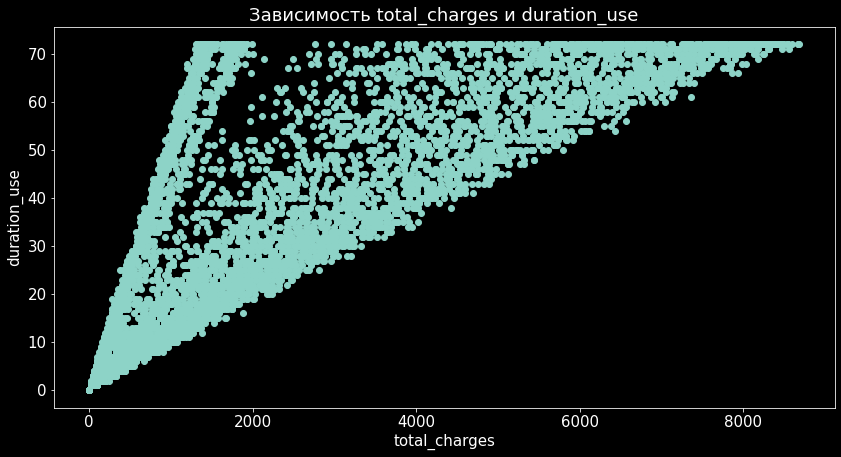

In [307]:
plt.figure(figsize=(14, 7))
plt.scatter(df['total_charges'], df['duration_use'])
plt.title("Зависимость total_charges и duration_use")
plt.xlabel("total_charges")
plt.ylabel("duration_use")
plt.show()

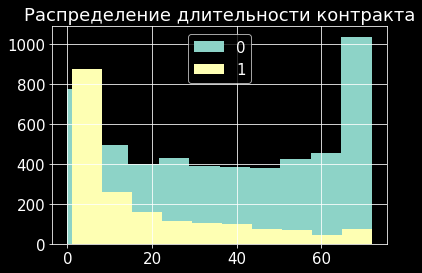

In [308]:
df[df['is_exited'] == 0]['duration_use'].hist()
df[df['is_exited'] == 1]['duration_use'].hist()
plt.title('Распределение длительности контракта')
plt.legend(['0', '1'])
plt.show()

In [309]:
pd.qcut(df['duration_use'], 6).unique()

[(-0.001, 4.0], (29.0, 47.0], (4.0, 14.0], (14.0, 29.0], (47.0, 64.0], (64.0, 72.0]]
Categories (6, interval[float64, right]): [(-0.001, 4.0] < (4.0, 14.0] < (14.0, 29.0] < (29.0, 47.0] < (47.0, 64.0] < (64.0, 72.0]]

In [310]:
df['duration_use_cut'] = pd.qcut(df['duration_use'], 6)

In [311]:
df.groupby(['duration_use_cut'])['is_exited'].agg(['count', 'mean'])

,count,mean
duration_use_cut,,
"(-0.001, 4.0]",1238,0.549273
"(4.0, 14.0]",1133,0.369815
"(14.0, 29.0]",1198,0.258765
"(29.0, 47.0]",1171,0.203245
"(47.0, 64.0]",1194,0.125628
"(64.0, 72.0]",1109,0.064923


Уловили зависимоть, чем меньше клиент подключен к услугам, тем вероятнее он от нас уйдет

In [312]:
df = df.drop(columns=['duration_use'])
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'type',
       'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_TV', 'streaming_movies',
       'multiple_lines', 'is_exited', 'is_phone', 'is_internet',
       'duration_use_cut'],
      dtype='object')

In [313]:
df.info()

## Получение дамми переменных для бинарных и категориальных признаков с удалением 1 столбца

In [314]:
df = pd.get_dummies(data=df, columns=[
    'gender', 'partner', 'dependents', 'paperless_billing', 'duration_use_cut', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_TV', 'streaming_movies', 'multiple_lines'
], drop_first=True)
df.head()

,senior_citizen,type,payment_method,monthly_charges,total_charges,internet_service,is_exited,is_phone,is_internet,gender_Male,...,"duration_use_cut_(29.0, 47.0]","duration_use_cut_(47.0, 64.0]","duration_use_cut_(64.0, 72.0]",online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_TV_Yes,streaming_movies_Yes,multiple_lines_Yes
0,0,Month-to-month,Electronic check,29.85,29.85,DSL,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,One year,Mailed check,56.95,1889.50,DSL,0,1,1,1,...,1,0,0,1,0,1,0,0,0,0
2,0,Month-to-month,Mailed check,53.85,108.15,DSL,1,1,1,1,...,0,0,0,1,1,0,0,0,0,0
3,0,One year,Bank transfer (automatic),42.30,1840.75,DSL,0,0,1,1,...,1,0,0,1,0,1,1,0,0,0
4,0,Month-to-month,Electronic check,70.70,151.65,Fiber optic,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [315]:
cat_features = ['type', 'payment_method', 'internet_service']

In [316]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :", start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings

            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)

            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)

                # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            try:
                result = (props[col] - asint)
                result = result.sum()
                if result > -0.01 and result < 0.01:
                    IsInt = True

                # Make Integer/unsigned Integer datatypes
                if IsInt:
                    if mn >= 0:
                        if mx < 255:
                            props[col] = props[col].astype(np.uint8)
                        elif mx < 65535:
                            props[col] = props[col].astype(np.uint16)
                        elif mx < 4294967295:
                            props[col] = props[col].astype(np.uint32)
                        else:
                            props[col] = props[col].astype(np.uint64)
                    else:
                        if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                            props[col] = props[col].astype(np.int8)
                        elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                            props[col] = props[col].astype(np.int16)
                        elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                            props[col] = props[col].astype(np.int32)
                        elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                            props[col] = props[col].astype(np.int64)

                            # Make float datatypes 32 bit
                else:
                    props[col] = props[col].astype(np.float32)

                # Print new column type
                print("dtype after: ",props[col].dtype)
                print("******************************")
            except TypeError:
                pass

    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist
df, NAlist = reduce_mem_usage(df)

# Построение моделей

- Разделим датасет на тренировочный и тестовые датасеты
- Обучим модель
- Получим вероятности отнесения к тому или иному классу
- Проанализируем результаты

In [317]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['is_exited'], axis=1), df['is_exited'], test_size=0.25, random_state=0, stratify=df['is_exited'])

In [318]:
pd.DataFrame(y_train)['is_exited'].mean(), pd.DataFrame(y_test)['is_exited'].mean()

(0.2654297614539947, 0.26519023282226006)

In [319]:
X_train.shape, X_test.shape

((5282, 24), (1761, 24))

## LogisticRegression

In [320]:
df_exited = df[df["is_exited"] == 1]
df_not_exited = df[df["is_exited"] == 0]
print(df_exited.shape, df_not_exited.shape)

In [321]:
df_exited = resample(
    df_exited,
    replace=True,
    n_samples=len(df_not_exited),
    random_state=0,
)

print(df_exited.shape, df_not_exited.shape)
df_union_all = pd.concat([df_exited, df_not_exited])

In [322]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    df_union_all.drop(['is_exited'], axis=1),
    df_union_all['is_exited'],
    test_size=0.25,
    random_state=0,
    stratify=df_union_all['is_exited'],
)

In [323]:
X_train_cat = pd.get_dummies(data=X_train_, columns=cat_features, drop_first=True)
X_test_cat = pd.get_dummies(data=X_test_, columns=cat_features, drop_first=True)

In [324]:
X_train_.shape[0] == X_train_cat.shape[0], X_test_.shape[0] == X_test_cat.shape[0]

(True, True)

In [325]:
X_train_cat.head()

,senior_citizen,monthly_charges,total_charges,is_phone,is_internet,gender_Male,partner_Yes,dependents_Yes,paperless_billing_Yes,"duration_use_cut_(4.0, 14.0]",...,streaming_TV_Yes,streaming_movies_Yes,multiple_lines_Yes,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No
1184,0,87.900002,1500.500000,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,1,1,0
853,0,64.349998,352.649994,1,1,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
3110,0,19.100000,19.100000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1059,0,90.599998,1943.199951,1,1,1,0,0,1,0,...,1,0,1,0,0,0,1,0,1,0
3061,1,106.400002,2483.500000,1,1,1,0,0,1,0,...,1,1,1,0,0,0,1,0,1,0


In [326]:
mm = MinMaxScaler()
X_train_cat_mm = mm.fit_transform(X_train_cat)
X_test_cat_mm = mm.transform(X_test_cat)

In [327]:
pd.DataFrame(X_train_cat_mm[:3])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.693035,0.172773,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.458706,0.040605,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.008458,0.002199,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [328]:
lr = LogisticRegression(max_iter=1000)

Перекрестная проверка на 5 фолдах

In [329]:
%%time

scores = cross_val_score(lr, X_train_cat_mm, y_train_, cv=5)
print(f"Средняя правильность: {scores.mean():.2f}")

In [330]:
lr.fit(X_train_cat_mm, y_train_)

LogisticRegression(max_iter=1000)

In [331]:
preds = lr.predict_proba(X_test_cat_mm)[:, 1]
preds[:5]

array([0.20766081, 0.06125447, 0.93931912, 0.8996249 , 0.28148088])

### Best Threshold

In [332]:
precision, recall, thresholds = precision_recall_curve(y_test_, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (
        thresholds[ix],
        fscore[ix],
        precision[ix],
        recall[ix],
    )
)

### Confusion matrix

In [333]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

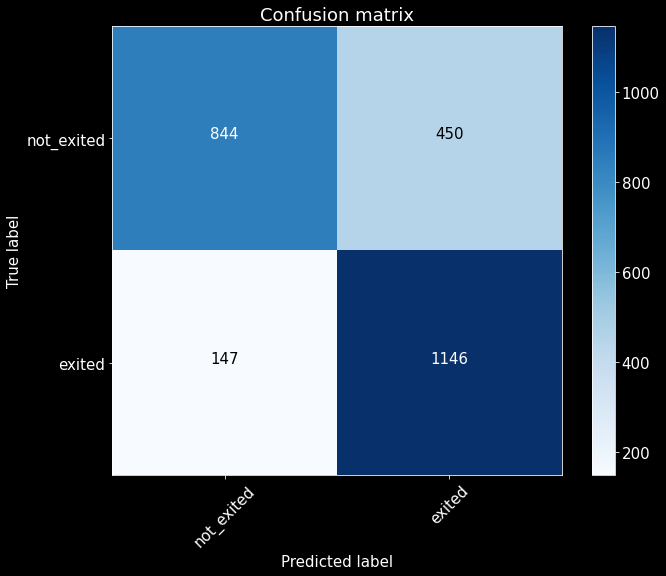

In [334]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['not_exited', 'exited'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Матрица ошибок визуально показывает что ошибка при отнесении наблюдения к 0, в то время как он относится к классу 1

### ROC curve

In [335]:
def roc_curve_plot(y_test, preds):
    fpr, tpr, _ = roc_curve(y_test,  preds)
    auc = roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(round(auc, 3)))
    plt.legend(loc=4)
    plt.title('Receiver Operating Characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

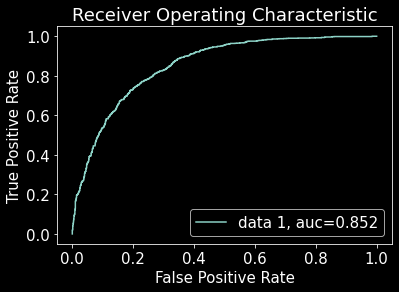

In [336]:
roc_curve_plot(y_test_,  preds)

### Feature importance

In [337]:
t = pd.DataFrame(abs(lr.coef_.T), columns=['coeff'])
t['col_names'] = list(X_train_cat.columns)
t.sort_values('coeff', ascending=False)

,coeff,col_names
22,1.935390,type_Two year
12,1.412283,"duration_use_cut_(47.0, 64.0]"
11,1.264038,"duration_use_cut_(29.0, 47.0]"
10,1.226550,"duration_use_cut_(14.0, 29.0]"
13,1.223237,"duration_use_cut_(64.0, 72.0]"
2,1.215980,total_charges
26,1.029206,internet_service_Fiber optic
9,0.794390,"duration_use_cut_(4.0, 14.0]"
21,0.788965,type_One year
4,0.552626,is_internet


### Classification Report

In [338]:
print(classification_report(y_test_, lr.predict(X_test_cat_mm), output_dict=False))

- Построили модель лог регрессии, она построилась быстро - около 136ms
- На максимизации fscore нашли threshold и построили confusion matrix
- У нас получилось что мы больше ошибаемся с FP - если мы будем предлагать купон или скидку то мы можем дать слишком много таких предложений
- Ошибки с FN - клиенты которые ушли, но мы никак с ними не проивзаимодействовали
- accuracy = 0.77 - доля правильным ответов по отношению ко всем ответам(изначально был выше, пока я не попробовала сделать upsampling, что наглядно показывает, что accuracy не надежная метрика при дисбалансе классов, в часности при использовании в лог регрессии. auc при этом, даже стал выше на 0.02)
- AUC ~ 0.85

## CatBoostClassifier

In [339]:
cb = CatBoostClassifier(
    cat_features=cat_features,
    random_seed=42,
)

In [340]:
# %%time

#cb.fit(X_train, y_train)

In [341]:
# %%time
#
# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6],
#         'l2_leaf_reg': [1, 3]}
#
# grid_search_result = cb.grid_search(
#     grid,
#     X=X_train,
#     y=y_train,
#     verbose=100,
#     plot=True,
# )
# grid_search_result['params']

In [342]:
%%time

cb = CatBoostClassifier(
    depth=6,
    l2_leaf_reg=1,
    learning_rate=0.1,
    cat_features=cat_features,
    verbose=100,
    random_seed=42,
)
cb.fit(X_train, y_train)

In [343]:
preds = cb.predict_proba(X_test)[:, 1]
preds[:5]

array([2.22025468e-01, 1.32866741e-01, 1.59065199e-04, 1.81430476e-04,
       2.49247245e-01])

Модель обучилась за ~30 секунд, получили скоры

### Best Threshold

In [344]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (
        thresholds[ix],
        fscore[ix],
        precision[ix],
        recall[ix],
    )
)

### Confusion matrix

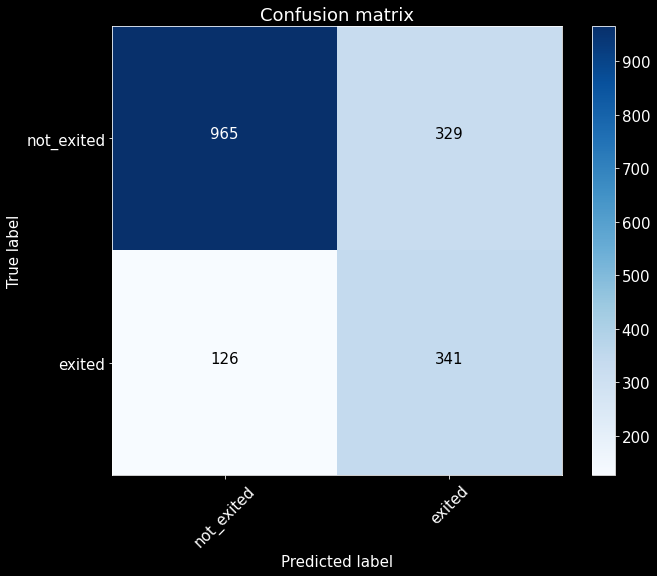

In [345]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['not_exited', 'exited'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Матрица ошибок визуально показывает что ошибка при отнесении наблюдения к 0, в то время как он относится к классу 1

### ROC curve

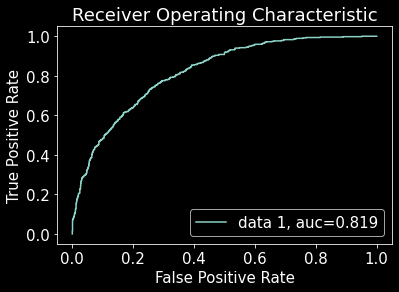

In [346]:
roc_curve_plot(y_test,  preds)

ROC кривая стремится к угловому варианту

### Feature importance

In [347]:
cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,total_charges,23.156802
1,monthly_charges,20.687487
2,type,10.493028
3,payment_method,7.425796
4,internet_service,5.381102
5,gender_Male,3.272818
6,paperless_billing_Yes,2.926822
7,dependents_Yes,2.781427
8,multiple_lines_Yes,2.373432
9,online_backup_Yes,2.214516


In [348]:
med, mean = cb.get_feature_importance(prettified=True)['Importances'].median(), cb.get_feature_importance(prettified=True)['Importances'].mean()
med, mean

(1.9961679484597097, 4.166666666666663)

### Classification Report

In [349]:
print(classification_report(y_test, cb.predict(X_test), output_dict=False))

- Построили модель классификации CatBoost, она строилась дольше - 30 сек
- На максимизации fscore нашли threshold и построили confusion matrix
- У нас получилось что мы больше ошибаемся с FP - как и с лог регрессией
- Ошибки с FN - клиенты которые ушли, но мы никак с ними не проивзаимодействовали
- Самые важные фичи по версии CatBoost являются type, duration_use, monthly_charges. duration_use все же пригодился
- accuracy = 0.79
- AUC ~ 0.81

## MLPClassifier

MLPClassifier требует что бы мы стандартизовали данные и не работает с категориальными фичами как CatBoost

In [350]:
%%time

mlp = MLPClassifier(
    solver='lbfgs',
    max_iter=1000,
    # hidden_layer_sizes=[10],
    alpha=0.1,
    random_state=0,
).fit(X_train_cat_mm, y_train_)

In [351]:
print(f"Скор на обучающем наборе: {mlp.score(X_train_cat_mm, y_train_)}\nСкор на тестовом наборе: {mlp.score(X_test_cat_mm, y_test_)}")

In [352]:
preds = mlp.predict_proba(X_test_cat_mm)[:, 1]
preds[:5]

array([3.16998265e-08, 4.57737346e-08, 9.99999873e-01, 9.27452800e-01,
       8.70678420e-07])

### Best Threshold

In [353]:
precision, recall, thresholds = precision_recall_curve(y_test_, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (
    thresholds[ix],
    fscore[ix],
    precision[ix],
    recall[ix],
)
      )

### Confusion matrix

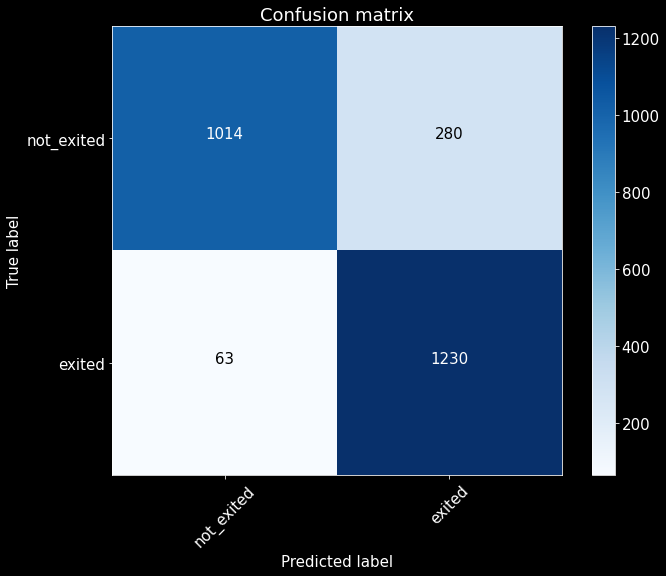

In [354]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_, preds > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['not_exited', 'exited'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### ROC curve

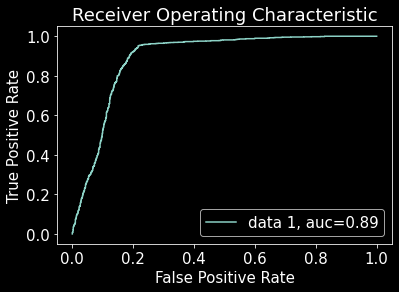

In [355]:
roc_curve_plot(y_test_,  preds)

### Classification Report

In [356]:
print(classification_report(y_test_, mlp.predict(X_test_cat_mm), output_dict=False))

- Построили модель MLPClissifier, она строилась относительно быстро, но при добавлении гиперпараметров требовала больше итераций и обучалась очень долго, при этом требовала предобработку по аналогии с логрегрессией - обработка кат фичей и стандартизацию признаков
- На максимизации fscore нашли threshold и построили confusion matrix
- У нас получилось что мы больше ошибаемся с FP - если мы будем предлагать купон или скидку то мы можем дать слишком много таких предложений
- Ошибки с FN - клиенты которые ушли, но мы никак с ними не проивзаимодействовали
- accuracy = 0.86 - доля правильным ответам по отношению ко всем ответам
- AUC ~ 0.89

## Общие выводы по моделям

- Все модели показали хороший результат, при этом по скорости лог регрессия: ~245ms, CatBoost: ~30 сек, MLP ~18.7сек
- По ROC получилось такое разбиение: лог регрессия - 0.85, CatBoost - 0.81, MLP - 0.89, при этом трэшхолд подтягивала до максимлаьного значения f-score как метрики, учитывающей и precision и recall. И здесь получались интересные различия в прогнозировании.
    - Лог регрессия имеет precision 0.78, что значит что из 100% маркетинговых предложений потенциально могут оправдать себя только 78% при этом 22% таких предложений уйдет нам в минус, если клиент согласится на дискаунт(хотя он изначально и не собирался уходить) и добавить к этому ошибку второго рода - FN, с которыми надо было взаимодействовать, но мы ничего не сделали и потеряли их.
    - CatBoost показал себя в целом неплохо и precision здесь 0.51
    - MLP отработал хорошо, хотя для него была необходима предобработка на уровне с лог регрессией. В процентном соотношении она меньше ошибается в предсказании отточных клиентов чем лог регрессия и пропускает тоже меньше.

## Расчет прибыли

Возьмем за стоимость купона - X, а стоимость выручки - Y(хотя мы знаем что у нас nunique() по месячной выручке 185 вариантов, тем не менее мы можем отталкиваться от 25% наших наблюдений и выше так как те кто ниже и так платят мало и не уходят, а это от 35 в месяц). Пусть выручка будет - 70 - это наша медиана

Подсчет без работы модели:
    - Не ушли 1296 + 2 = 1298. 1298 * 70 = 90860
    - Остальные клиенты ушли в отток и мы потеряли 450 + 13 = 463. 463 * (70 - X) - наша потенциальная прибыль, если бы мы взаимодействовали с клиентом

Подсчет с применением методов ML:
    - Не ушли 1296 * 70 = 90720 и мы заработали не взаимодействуя с клиентом
    - Потенциально хотели уйти в отток, но мы их привлекли купоном на скидку - 450. Тогда 450 * (70 - X) - Это наша возможная прибыль
    - Не собирались уходить, но мы преложили скидку и заработали 2 * (70 - X)
    - Тем не менее все равно ушли 13 клиентов и мы потеряли 13 * (70 - X)

In [357]:
TP = 450
FP = 2
FN = 13
TN = 1296

def count_money(x):
    income = 90720 + FP * (70 - x)
    may_be_income = TP * (70 - x)
    lost_income = FN * (70 - x)
    spend_money = (FP + TP)*x
    print(f"Пессимистичный прогноз при котором наша акция не сработала: {income - spend_money}")
    print(f"Реалистичный прогноз при котором наша акция сработала на 50% клиентов: {income + may_be_income * 0.5 - spend_money}")
    print(f"Оптимистичный прогноз при котором наша акция сработала на 100% клиентов: {income + may_be_income - spend_money}")
    print(f"При этом мы потратили: {(FP+TP)*x}")
    print(f"При этом мы недополучили: {lost_income}")

result = {}

In [358]:
count_money(5)

In [359]:
count_money(10)

In [360]:
count_money(15)

In [361]:
count_money(23)

Т.о. если мы отталкиваемся от стартовой прибыли без маркетинговой акции в 90860, то при использовании модели мы должны быть уверены что акцией воспользуются как минимум 50% клиентов, при этом стоимость траты на одного клиента должна быть не выше чем 23 условные единицы. Тогда за месяц мы окупимся и хотя бы часть клиентов останется с нами. При это расчет ведется исходя из того что мы удерживаем клиента и в течении месяца это нам окупается, а далее он пользуется услугами и приносит прибыль без затрат.

# Отчет

- Необходимо было сравнить распределение величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл - выполнено с поправкой что я сранивла распределение тех кто ушел и тех кто не ушел, на мой взгляд это было так же информативно.
- Для каждой группы посчитайте статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей - выполнено с помощью метода describe()
- Постройте гистограммы распределения. - гистограммы построены.
- Выяснили:
    - Можно отметить, что клиенты, которые ушли в среднем платят в месяц больше тех кто не ушел: 74 против 61.
    - Те, кто не ушли в отток часто платят мало, это около 20 в месяц и таких наблюдений более 1400, в то время как те кто ушли и платили около 20 - их всего менее 200.
    - Такие же "провалы" наблюдаются в платежах около 60 и 110, в остальном графики распределения изменяются примерно одинаково.
    - Можно сделать вывод что цена ежемесячной платы влияет на отток в той части, если клиент платит минимальную сумму платежа, то он врядли уйдет, а нам соответственно "выгоднее" сосредоточиться на тех клиентах, которые платили более 70 в месяц(допустим), так как тренд на гистограмме возрастает резко именно в этом месте для тех кто ушел.
    - Для клиентов которые пользуются телефонией нет разницы в оттоке, они уходят одинаково часто
    - А вот для отточников среди тех кто пользуется интернетом выше: 93% против 72%
    - Так же выяснили, что тип пакета клиента сильно влияет на отточность: среди всех отточников 1665 имеют пакет month-to-month, в то время как пакеты one year и two years в сумме отточников всего 166+48
- Далее поработали с фичами:
    - 'customer_id', 'begin_date', 'end_date' - удалили, так как они не влияют на таргет или модели их не обрабатывают
    - total_charges были с пропущенными значениями - это клиенты которые недавно стали клиентами и у них еще не было оплаты - проставили пропуски 0
    - прекодировали кат фичи в дамми переменные
    - был введен признак duration_use - длительность пользования контрактом, из-за его сильной линейной корреляцией с total_charges перекодировали его в кат признак с помощью qcut - Уловили зависимоть, чем меньше клиент подключен к услугам, тем вероятнее он от нас уйдет
- Построили модели Лог регрессии, CatBoost, MLPClassifier:
    - Для лог регрессии обработали дополнительно кат фичи, которые CatBoost обработал сам. Использовали так же шкалирование фичей, что бы модель не завышала важность признаков с помощью MinMaxScaler. Тоже самое для MLPClassifier.
    - Лучше всего себя показала модель MLPClassifier - она хорошо находит наблюдения, относящиесся к 1 классу, при этом не сильно ошибается.
    - При определении отсечки - Threshold - брала точку при которой максимизируется метрика fscore как метрика, которая усредняет precision и recall, так как нам важно не только не пропустить отточных клиентов, но и не много ошибаться, так как бизнес кейс раздачи купона на скидку подразумевает что мы можем ошибиться и дать скидку тем, кто с отток не уходил.
- Трудности при анализе данных и построении моделей:
    - Подобрать нужные фичи и корректным образом подать их в модель, например исключить сильную корреляцию непрерывных фичей, каким образом обработать и т.п. В моем случае преобразовать фичу duration_use - изначально я попробовала на 3 интервала,потом сделала 6 и стало лучше, исходила из того что у нас 6 лет наблюдений.
    - Подобрать гиперпараметры, улучшить качество модели таким образом.
    - В MLPClassifier не так просто сделать feature importance потому что это нейронка, но хотя бы удалось сделать это в других моделях.
